In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################


## NeuralNetwork PaySim

In the another notebook, an XGBoost model was trained on the [Paysim Dataset](https://www.kaggle.com/ntnu-testimon/paysim1). In this notebook, a Neural Network model will be built and trained on a NVIDIA GPU using PyTorch.


In [1]:
%matplotlib inline
from pathlib import Path  # to provide platform independent path handling
import os

import cudf
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from tqdm.autonotebook import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_auc_score, accuracy_score, \
                            precision_score, recall_score

# set seaborn style because it prettier
sns.set()

# Paysim dataset downloaded and extracted
data_path = './data/PS_20174392719_1491204439457_log.csv'
print(f'Data Path: {Path(data_path)}')

Data Path: data/PS_20174392719_1491204439457_log.csv


<ipython-input-1-101e24fada8e>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


###  Data Processing Pipeline and build train/val/test datasets

In [2]:

txns = cudf.read_csv(Path(data_path))

# renaming columns to conform to camelCase as in the XGBoost notebook
txns = txns.rename(columns={'oldbalanceOrg': 'oldBalanceOrig', 'newbalanceOrig': 'newBalanceOrig',
                            'oldbalanceDest': 'oldBalanceDest', 'newbalanceDest': 'newBalanceDest'})

numerical_cols = ['amount', 'oldBalanceOrig',
                  'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest']


# adjust dtypes for perf.
txns[numerical_cols] = txns[numerical_cols].astype(np.float32)
txns['step'] = txns['step'].astype(np.int32)
txns['isFraud'] = txns['isFraud'].astype(np.int32)

txns['errorBalanceOrig'] = txns.newBalanceOrig + txns.amount - txns.oldBalanceOrig
txns['errorBalanceDest'] = txns.oldBalanceDest + txns.amount - txns.newBalanceDest
txns['errorOrigAmount'] = txns.oldBalanceOrig - txns.amount

Examining various numerical transformations

In [3]:

class Log1pNumericalColsTransformer(BaseEstimator, TransformerMixin):
    """Applies np.log1p to passed cols"""

    def __init__(self, cols: list):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, data):
        data[self.cols] = np.log1p(data[self.cols])
        return data


class MakeDummiesTransformer(BaseEstimator, TransformerMixin):
    """Applies pd.dummies to passed cols"""

    def __init__(self, cols=None):
        if cols is None:
            cols = []
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, data: pd.DataFrame):
        if not self.cols:
            return pd.get_dummies(data)
        return cudf.get_dummies(data, columns=self.cols)


class ColDropTransformer(BaseEstimator, TransformerMixin):
    """Drops passed cols from pd.DataFrame"""

    def __init__(self, cols: list):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, data: pd.DataFrame):
        if not self.cols:
            return data
        return data.drop(columns=self.cols, axis=1)


class ColIsInTransformer(BaseEstimator, TransformerMixin):
    """runs df.loc[df.col.isin(values)]"""

    def __init__(self, col: str, values: list):
        if not isinstance(col, str):
            raise ValueError('col param must be type string')
        if not isinstance(values, list):
            raise ValueError('values param should be a list')
        self.col = col
        self.is_in_values = values

    def fit(self, X, y=None):
        return self

    def transform(self, data: pd.DataFrame):
        return data.loc[data[self.col].isin(self.is_in_values)]


class ErrorBalTransformer(BaseEstimator, TransformerMixin):
    """creates errorBalance feature cols"""

    def __init__(self, ):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, data: pd.DataFrame):
        data['errorBalanceOrig'] = data['newBalanceOrig'] + data['amount'] - data['oldBalanceOrig']
        data['errorBalanceDest'] = data['oldBalanceDest'] + data['amount'] - data['newBalanceDest']
        data['errorOrigAmount'] = data['oldBalanceOrig'] - data['amount']
        return data


In [4]:
# preprocess pipeline
pipe = Pipeline([('col_is_in', ColIsInTransformer('type', ['TRANSFER', 'CASH_OUT'])),
                 ('col_drop', ColDropTransformer(['nameOrig', 'nameDest', 'isFlaggedFraud'])),
                 ('make_dummies', MakeDummiesTransformer(['type'])),
                 ('errorBalcols', ErrorBalTransformer()),
                 # add your custom steps here!
                 # If any scaling is performed on the data,
                 # make sure you only fit to the train data! 
                 # The make_dummies above will make one-hot cols but we only select 
                 # ex. 'type_CASH_OUT', 'type_TRANSFER' which are present in both train/test datasets
                 ])

In [5]:
col_order = ['step', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest',
             'errorBalanceOrig', 'errorBalanceDest', 'errorOrigAmount', 'type_CASH_OUT', 'type_TRANSFER',
             'isFraud']

numerical_cols = ['amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
                  'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'errorOrigAmount']

train_cols = col_order[:-1]

# basic preprocessing to all columns, no estimator used since we'll be training a Neural Network.
df = pipe.fit_transform(txns)
df = df[col_order]

# note df is passed to make train and test
# and train is passed again to make train and val
train_val, test_df = train_test_split(df, test_size=0.1, shuffle=True,
                                   random_state=314, stratify=df.isFraud.values.get())

train_df, val_df = train_test_split(train_val, test_size=0.1, shuffle=True,
                              random_state=314, stratify=train_val.isFraud.values.get())

del train_val

assert len(train_df) + len(val_df) + len(test_df) == len(df)


def get_df_back(scaled, df: pd.DataFrame, scaled_cols: list) -> pd.DataFrame:
    """
    Applying sklearn scaler returns values as numpy array when passed a pandas DataFrame.
    The function here creates a DataFrame using the scaled values and including whatever missing cols are in
    `df` but not in `scaled_cols`

    Examples:
        df.columns = [numerical1, numerical2, categorical1]
        scaler = StandardScaler()
        output = scaler.fit_transform(df[[numerical1, numerical2]])
        df = get_df_back(scaled=output, df, [numerical1, numerical2])
    Args:
        scaled: np.array 
        df: pd.DataFrame
        scaled_cols (list): list of columns passed for scaling.

    Returns:

    """
    missing_cols = [i for i in df.columns if i not in scaled_cols]
    new_df = pd.concat([pd.DataFrame(scaled, columns=scaled_cols, index=df.index),
                       df[missing_cols]], axis=1)
    # keep ordering the same as the original df
    return new_df[df.columns]


In [6]:
len(train_df), len(val_df), len(test_df)

(2244031, 249337, 277041)

In [7]:
train_df

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest,errorOrigAmount,type_CASH_OUT,type_TRANSFER,isFraud
436823,18,2.051071e+05,691537.125,486430.0625,7.477576e+05,7.247454e+05,0.000000,2.281193e+05,486430.031250,1,0,0
6113886,527,1.094420e+06,1094419.875,0.0000,0.000000e+00,0.000000e+00,0.000000,1.094420e+06,0.000000,0,1,1
223194,14,2.471754e+04,0.000,0.0000,2.380768e+05,2.627943e+05,24717.539062,0.000000e+00,-24717.539062,1,0,0
2577750,207,1.016443e+05,0.000,0.0000,3.301527e+05,4.317969e+05,101644.257812,0.000000e+00,-101644.257812,1,0,0
628923,34,2.093765e+05,103143.000,0.0000,2.538365e+07,2.559303e+07,106233.453125,0.000000e+00,-106233.453125,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6060883,500,5.932620e+03,0.000,0.0000,3.498703e+05,3.558029e+05,5932.620117,0.000000e+00,-5932.620117,1,0,0
4978323,352,6.515725e+04,79278.000,14120.7500,6.721660e+03,7.187892e+04,0.000000,-1.562500e-02,14120.750000,1,0,0
4510976,325,1.932593e+05,0.000,0.0000,4.833633e+05,6.766226e+05,193259.312500,0.000000e+00,-193259.312500,1,0,0
5334291,374,2.599351e+05,10642.000,0.0000,7.846657e+05,1.044601e+06,249293.062500,0.000000e+00,-249293.062500,1,0,0


<AxesSubplot:>

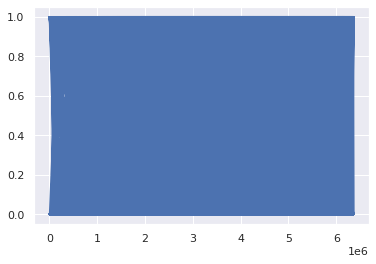

In [9]:
train_df.isFraud.to_pandas().plot()

<AxesSubplot:>

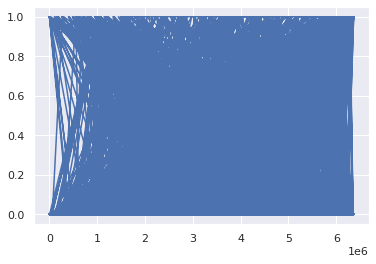

In [10]:
val_df.isFraud.to_pandas().plot()

<AxesSubplot:>

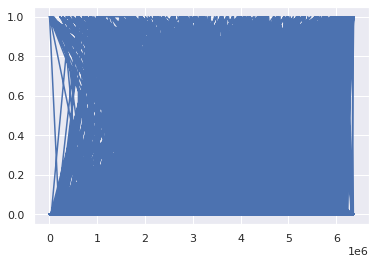

In [11]:
test_df.isFraud.to_pandas().plot()

#### Class Rebalancing - SMOTE, RandomOverSampler - uncomment if desired

In [12]:
# Train Set whats the class imbalance like?
# train_df.isFraud.value_counts()

0    2237378
1       6653
Name: isFraud, dtype: int32

In [13]:
# print(f'Fraud present in {100*train_df.isFraud.sum(dtype=cp.int64)/len(train_df):0.3f}% of cases')

Fraud present in 0.296% of cases


In [14]:
# # use SMOTENC when data is mixed numerical and categorical features
# from imblearn.over_sampling import SMOTENC, RandomOverSampler
# import time
# start = time.time()

# # learn more about Synthetic Minority Over-sampling Technique for Nominal and Continuous here:
# # https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html


# categorical = [train_cols.index(i) for i in train_cols if i in ['step', 'type_CASH_OUT', 'type_TRANSFER']]
# # sampler = SMOTENC(categorical_features=categorical, random_state=777, n_jobs=-1)
# sampler = RandomOverSampler(random_state=8_675_309)  # Jenny

# X_resampled, y_resampled = sampler.fit_resample(train_df[train_cols].to_pandas(),
#                                                 train_df['isFraud'].to_pandas())

# end = time.time()
# print(end-start)  # 150s for SMOTE_NC,  ~0.75s for RandomOverSampler on my machine

0.8281455039978027


In [15]:
# # whats the class imbalance like now?
# y_resampled.value_counts()

0    2237378
1    2237378
Name: isFraud, dtype: int64

In [16]:
# # make our train_df again with the balanced data.
train_df = cudf.concat([cudf.DataFrame.from_pandas(X_resampled), 
                         cudf.Series.from_pandas(y_resampled)], axis=1)[col_order]

<AxesSubplot:>

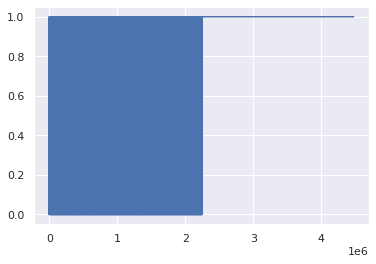

In [17]:
# as you see from plot below, shuffling dataset is desired if using SMOTE.
train_df.isFraud.to_pandas().plot()

### re-visualize

In [12]:
col_order

['step',
 'amount',
 'oldBalanceOrig',
 'newBalanceOrig',
 'oldBalanceDest',
 'newBalanceDest',
 'errorBalanceOrig',
 'errorBalanceDest',
 'errorOrigAmount',
 'type_CASH_OUT',
 'type_TRANSFER',
 'isFraud']

<AxesSubplot:>

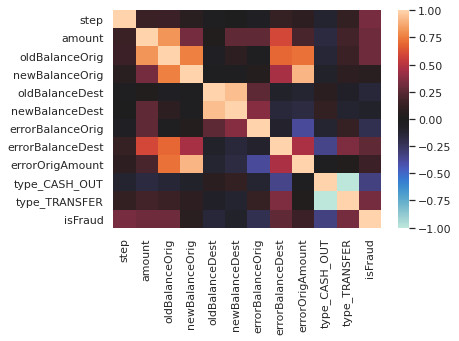

In [18]:
# visualize correlation matrix ..

sns.heatmap(train_df[col_order].corr().to_pandas(), center=0)

#### More Scaling

0 0 None
1 0 initial_probplot
2 0 StandardScaler
3 0 PowerTransformer
4 0 QuantileTransformer
5 0 MinMaxScaler
6 0 RobustScaler
0 1 None
1 1 initial_probplot
2 1 StandardScaler
3 1 PowerTransformer
4 1 QuantileTransformer
5 1 MinMaxScaler
6 1 RobustScaler
0 2 None
1 2 initial_probplot
2 2 StandardScaler
3 2 PowerTransformer
4 2 QuantileTransformer
5 2 MinMaxScaler
6 2 RobustScaler
0 3 None
1 3 initial_probplot
2 3 StandardScaler
3 3 PowerTransformer
4 3 QuantileTransformer
5 3 MinMaxScaler
6 3 RobustScaler
0 4 None
1 4 initial_probplot
2 4 StandardScaler
3 4 PowerTransformer
4 4 QuantileTransformer
5 4 MinMaxScaler
6 4 RobustScaler


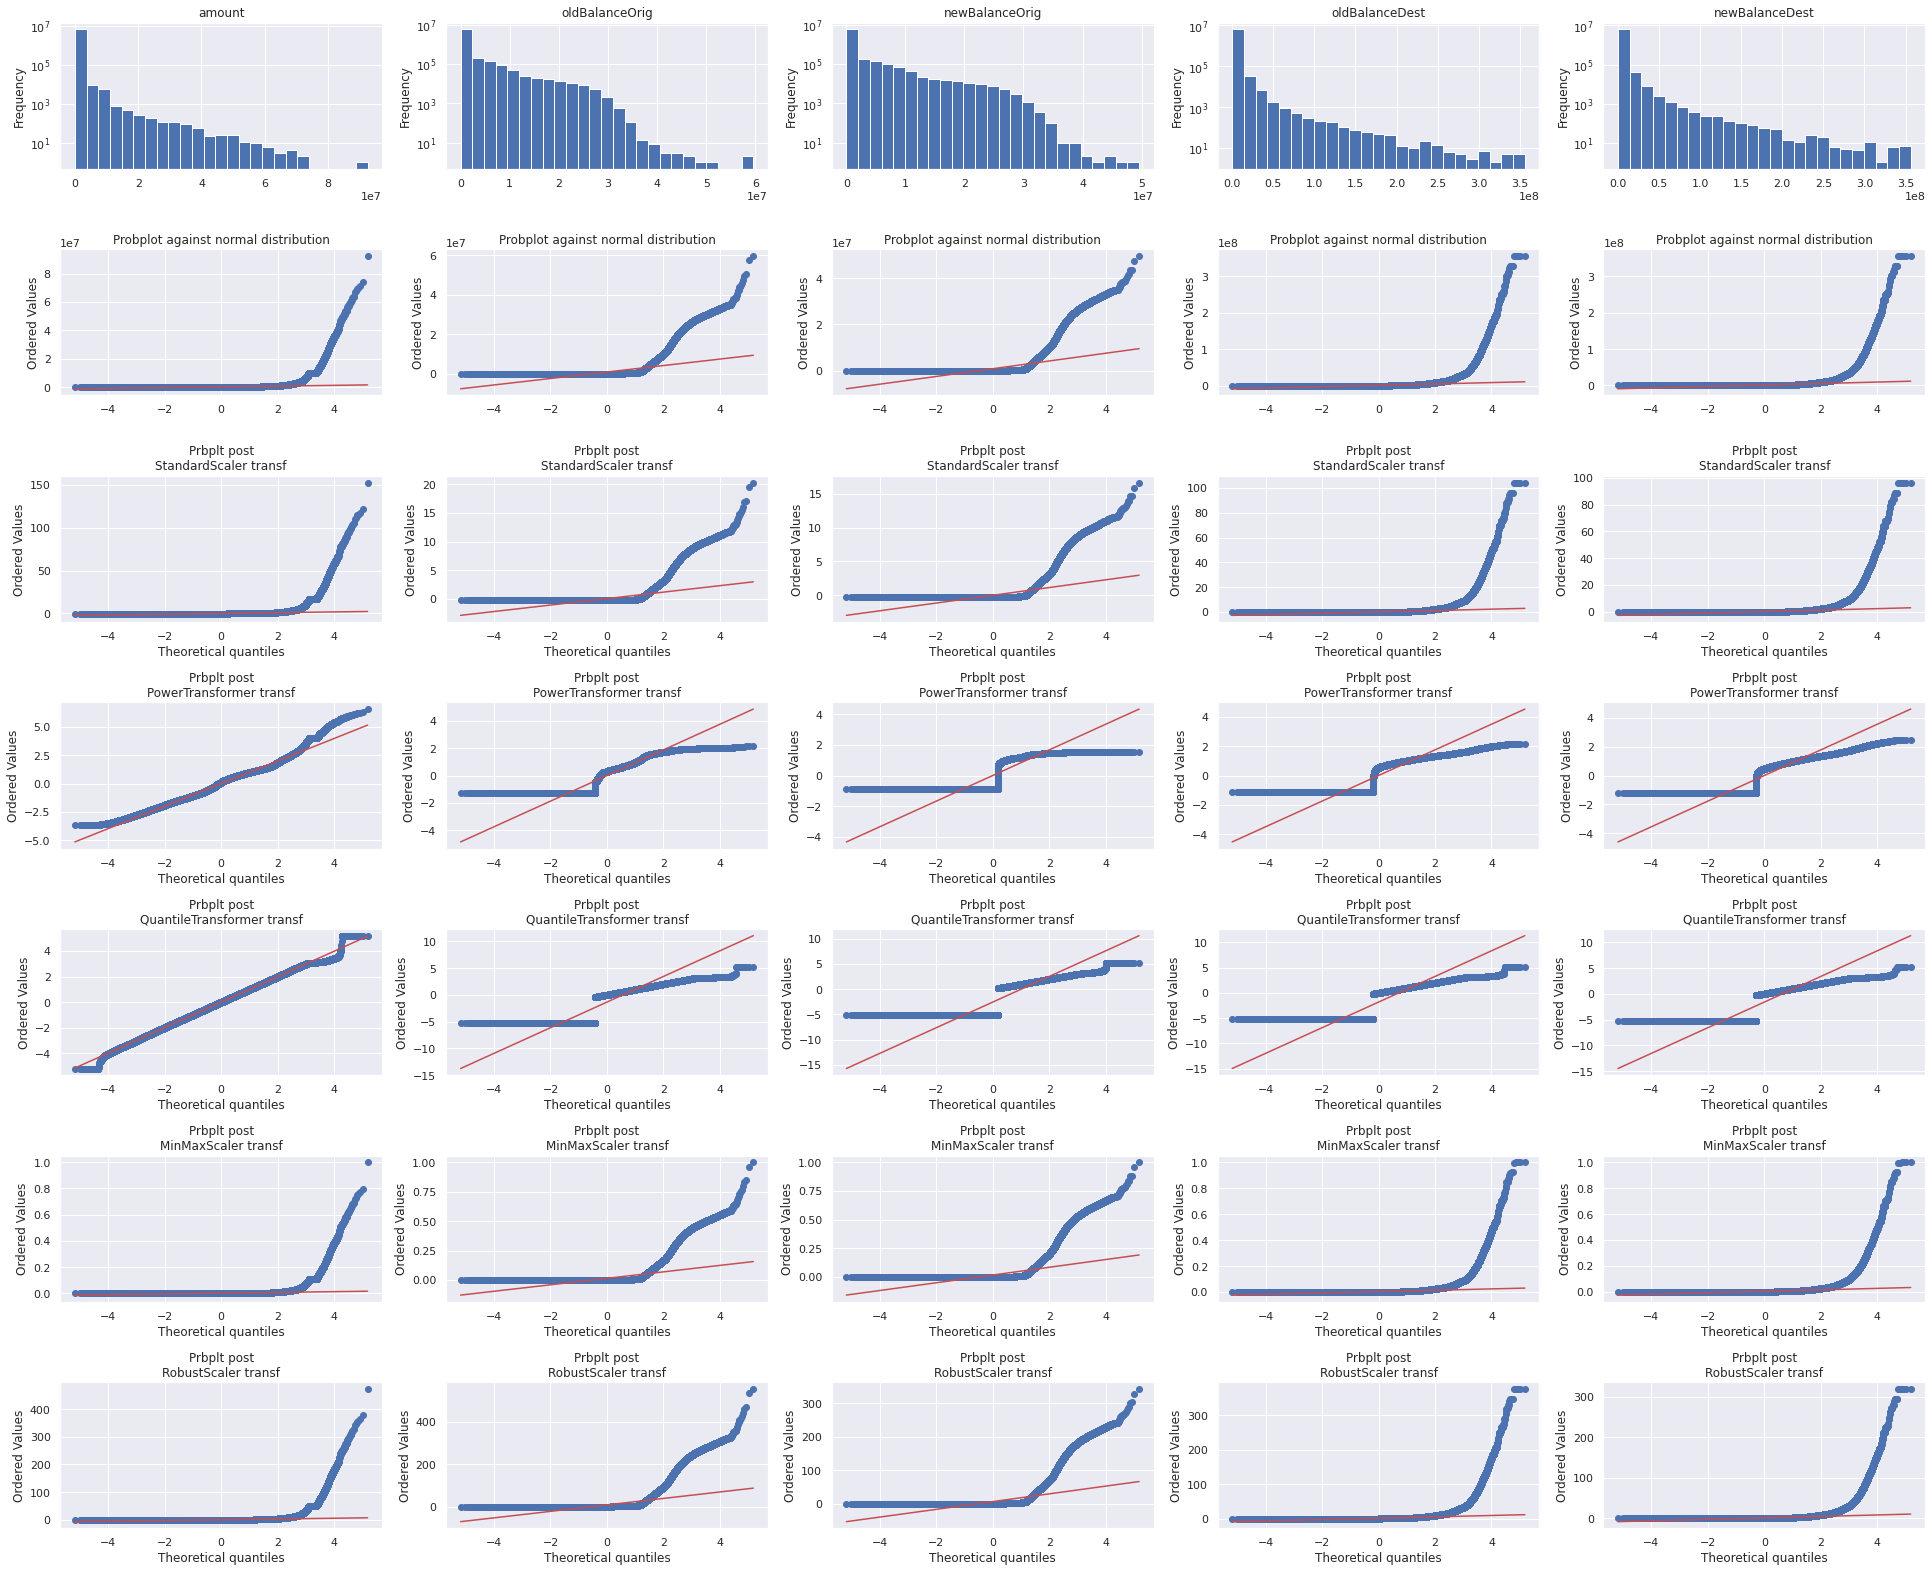

In [19]:
# SLOW - can skip this cell
# Why not smack the numerical cols with a hammer of transforms?
# You can then pick one that suits the problem the best, if desired.
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, MinMaxScaler, RobustScaler

numerical_cols = ['amount', 'oldBalanceOrig',
                  'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest']
trsnforms = [None,
             'initial_probplot',
             'StandardScaler',
             'PowerTransformer',
             'QuantileTransformer',
             'MinMaxScaler',
             'RobustScaler'
             ]
nrows, ncols = len(trsnforms), len(numerical_cols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(27, 22))

_txns = txns.to_pandas()


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    for col in range(ncols):
        for row, transform in zip(range(nrows), trsnforms):
            print(row, col, transform)
            if not transform:
                _txns[numerical_cols[col]].plot(
                    kind='hist', ax=ax[row][col], bins=25, logy=True, title=numerical_cols[col])

                continue
            elif transform == 'initial_probplot':
                prob = stats.probplot(
                    _txns[numerical_cols[col]].values, dist=stats.norm, plot=ax[row][col])

                ax[row][col].set_xlabel('')
                ax[row][col].set_title('Probplot against normal distribution')
                continue
            elif transform == 'StandardScaler':
                scaler = StandardScaler()
            elif transform == 'PowerTransformer':
                scaler = PowerTransformer(method='yeo-johnson', standardize=True)
            elif transform == 'QuantileTransformer':
                scaler = QuantileTransformer(output_distribution='normal')
            elif transform == 'MinMaxScaler':
                scaler = MinMaxScaler()
            elif transform == 'RobustScaler':
                scaler = RobustScaler()

            xt = scaler.fit_transform(_txns[[numerical_cols[col]]])
            prob = stats.probplot(xt.squeeze(), dist=stats.norm, plot=ax[row][col])
            ax[row][col].set_title(f'Prbplt post\n{transform} transf')

plt.tight_layout()
# plt.savefig('transformslog1p.png')
plt.show()

We could pick one of these transforms that is the most linear and apply the fit to the train data. We can leave that for an exercise. The high number of zeros in some columns ia apparent.

# Models

We make a simple feedforward network and a second `fun` network that generates embeddings, and later adds outputs from 2 separate layers together.  

In [13]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

TRAIN_BATCH_SIZE = 512

cuda:0


In [14]:
class NNModel(nn.Module):
    def __init__(self, input_cols: list, hidden_dim=16):
        super(NNModel, self).__init__()
        self._name = f'NNModel_{hidden_dim}'

        self.fc1 = nn.Linear(in_features=len(input_cols), out_features=hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.norm3 = nn.BatchNorm1d(hidden_dim)
        self.relu3 = nn.ReLU()
        
        self.output_layer = nn.Linear(in_features=hidden_dim, out_features=1)


    def forward(self, inp):
        
        x = self.relu1(self.norm1(self.fc1(inp)))
        x = self.relu2(self.norm2(self.fc2(x)))
        x = self.relu3(self.norm3(self.fc3(x)))

        logits = self.output_layer(x)
#         print(logits)
        return logits


class FunNet(nn.Module):
    def __init__(self, input_cols: list, embedding_dim=24, hidden_dim=256, dropout_rate=0.1):
        super(FunNet, self).__init__()
        self._name = f'NNModel_{embedding_dim}_{hidden_dim}'
        
        self._cols = {col:idx for idx, col in enumerate(input_cols)} 
        self.dropout_rate = dropout_rate
        
        self.step_embeddings = nn.Embedding(760, embedding_dim)
        self.type_CASH_OUT_embeddings = nn.Embedding(2, 1)
        self.type_TRANSFER_embeddings = nn.Embedding(2, 1)
        
        self.fc1 = nn.Linear(in_features=8+embedding_dim + 2, out_features=hidden_dim)
        self.norm1 = nn.BatchNorm1d(num_features=hidden_dim)
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(self.dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.prelu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(self.dropout_rate)
                
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=1)


    def get_embed(self, x, embed):
        s0 = x.shape[0]
        x = embed(x)      
        # lag_embed.shape: bs, x.shape[1], embedding_dim
        x = x.view(s0, -1)
        return x
    
    def forward(self, inp):
        # generate categorical embeddings

        step_embed = self.get_embed(inp[:, self._cols['step']].to(torch.int32), self.step_embeddings)
        transfer_embed = self.get_embed(inp[:, self._cols['type_TRANSFER']].to(torch.int32), self.type_TRANSFER_embeddings)
        cash_out_embed = self.get_embed( inp[:, self._cols['type_CASH_OUT']].to(torch.int32), self.type_CASH_OUT_embeddings)
        
        amount = inp[:, self._cols['amount']].to(torch.float32).unsqueeze(1)
        oldBalanceOrig = inp[:, self._cols['oldBalanceOrig']].to(torch.float32).unsqueeze(1)
        newBalanceOrig = inp[:, self._cols['newBalanceOrig']].to(torch.float32).unsqueeze(1)
        oldBalanceDest = inp[:, self._cols['oldBalanceDest']].to(torch.float32).unsqueeze(1)
        newBalanceDest = inp[:, self._cols['newBalanceDest']].to(torch.float32).unsqueeze(1)
        errorBalanceOrig = inp[:, self._cols['errorBalanceOrig']].to(torch.float32).unsqueeze(1)
        errorBalanceDest = inp[:, self._cols['errorBalanceDest']].to(torch.float32).unsqueeze(1)
        errorOrigAmount = inp[:, self._cols['errorOrigAmount']].to(torch.float32).unsqueeze(1)
        
#         x = (step_embed + transfer_embed + cash_out_embed)
#         print('merge', x.shape)
        x = torch.cat([amount, oldBalanceOrig, newBalanceOrig, oldBalanceDest, newBalanceDest,
                       errorBalanceOrig, errorBalanceDest, errorOrigAmount, 
                       step_embed, transfer_embed, cash_out_embed],-1)
#         print('cat', x.shape)
        x = self.prelu1(self.norm1(self.fc1(x)))
        x = self.dropout1(x)
#         print('layer1', x.shape)
        y = self.prelu2(self.norm2(self.fc2(x)))
#         print('y', y.shape)
        x = x + y  # fun: re-add the activations...
        x = self.dropout2(x)
        
        logits = self.fc3(x)
        return logits
    


In [15]:
import os
import torch
from typing import Union


def save_checkpoint(model, optimizer, epoch: int, best_score, file_name, threshold, k_fold=0):
    """
    Save checkpoint to pytorch .pt file.
    Args:
        model: Instance of Pytorch model.
        optimizer: pytorch optimizer ex. torch.optim.Adam() instance
        epoch: epoch number
        best_score: model best score acccoring to appropriate metric.
                    Can be multiple, just save as a dict. of {'metric': score}
        k_fold: int or string for K-folds.
        file_name (str): filename usually including the name of the model.:

    Returns:

    """
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'k_fold': k_fold,
        'epoch': epoch,
        'best_score': best_score,
        'threshold': threshold
    }
    os.makedirs(f'./checkpoints/', exist_ok=True)

    torch.save(checkpoint, f'./checkpoints/{file_name}.pt')


def load_checkpoint(file_name: str, model, device: str):
    """
    Load Checkpoint from pytorch .pt file.

    Args:
        k_fold: int or string for K-folds.
        device: str
        file_name (str): filename usually including the name of the model.
        model_cls: (uninstantiated) class belonging to a custom nn.Module
        **kwargs:

    Returns:

    """
    # instantiate the model and pass in input params as kwargs.
    model = model.to(device)

    checkpoint = torch.load(f'./checkpoints/{file_name}.pt')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model, checkpoint['threshold']


# Training with NVTabular or Pytorch Dataset

We demonstrate how to build an NVTabular Dataloader and Pytorch Dataset and Dataloader for training

In [19]:

col_order = ['step', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
             'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'errorOrigAmount', 
             'type_CASH_OUT', 'type_TRANSFER', 'isFraud']

## NVTabular + Pytorch Training

### Build an NVTabular Dataloader

In [20]:
import nvtabular as nvt
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader

nvt.__version__

'0.5.3'

In [21]:
# nvtabular will require the dtypes to be the same per data class kind
# (all cats the same dtype, all conts the same dtype)
train_df.type_CASH_OUT = train_df.type_CASH_OUT.astype(cp.int32)
train_df.type_TRANSFER = train_df.type_TRANSFER.astype(cp.int32)
val_df.type_CASH_OUT = val_df.type_CASH_OUT.astype(cp.int32)
val_df.type_TRANSFER = val_df.type_TRANSFER.astype(cp.int32)
test_df.type_CASH_OUT = test_df.type_CASH_OUT.astype(cp.int32)
test_df.type_TRANSFER = test_df.type_TRANSFER.astype(cp.int32)

CATEGORICAL_COLUMNS = ['step', 'type_CASH_OUT', 'type_TRANSFER']
CONTINUOUS_COLUMNS = ['amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
                      'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'errorOrigAmount']
LABEL_COLUMNS = ['isFraud']

train_dataset = TorchAsyncItr(
   nvt.Dataset(train_df),
   cats=CATEGORICAL_COLUMNS,
   conts=CONTINUOUS_COLUMNS,
   labels=LABEL_COLUMNS,
   batch_size=TRAIN_BATCH_SIZE,
   shuffle=True
)

train_loader = DLDataLoader(
   train_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)

val_dataset = TorchAsyncItr(
   nvt.Dataset(val_df),
   cats=CATEGORICAL_COLUMNS,
   conts=CONTINUOUS_COLUMNS,
   labels=LABEL_COLUMNS,
   batch_size=TRAIN_BATCH_SIZE,
   shuffle=True
)

val_loader = DLDataLoader(
   val_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)

test_dataset = TorchAsyncItr(
   nvt.Dataset(test_df),
   cats=CATEGORICAL_COLUMNS,
   conts=CONTINUOUS_COLUMNS,
   labels=LABEL_COLUMNS,
   batch_size=TRAIN_BATCH_SIZE,
   shuffle=True
)

test_loader = DLDataLoader(
   test_dataset,
   batch_size=None,
   pin_memory=False,
   num_workers=0
)

# nvtabular will alphabetically sort the columns
nvt_cols = sorted(CATEGORICAL_COLUMNS) + sorted(CONTINUOUS_COLUMNS)
print(nvt_cols)



['step', 'type_CASH_OUT', 'type_TRANSFER', 'amount', 'errorBalanceDest', 'errorBalanceOrig', 'errorOrigAmount', 'newBalanceDest', 'newBalanceOrig', 'oldBalanceDest', 'oldBalanceOrig']


In [20]:
# # make sure batches are roughly uniformly distributed...

# st = []
# for i in range(len(train_loader)):
#     st.append(train_df.isFraud.iloc[i*512:(i+1)*512].sum())

# fig, ax = plt.subplots()
# ax.plot(st)

In [ ]:
# # uncomment models to check different models with a single batch input.

# progress_bar = tqdm(range(len(train_loader)))
# st = []
# for _, (x_cat, x_cont, target) in zip(progress_bar, iter(train_loader)):
#     progress_bar.set_description('check progress bar')
#     st.append(target.sum().cpu())
#     break

# batch = torch.cat([x_cat, x_cont], dim=1)

# model = FunNet(input_cols=nvt_cols).to('cuda')
# model = NNModel(input_cols=nvt_cols).to('cuda')

# out = model(batch)

# out.cpu()

In [22]:
len(train_loader)

4383

### Build Utility functions - Train Loop and Val/Test Loop

In [25]:
def train_epoch(loader, model, optimizer, loss_func, device):
    """Train model through a single epoch"""
    # set model into train mode and zero all parameter gradients
    model.train()
    model.zero_grad()
    progress_bar = tqdm(range(len(loader)))
    train_loss = torch.zeros(len(loader), requires_grad=False, device=device) #[]
    
    for _, (x_cat, x_cont, target) in zip(progress_bar, iter(loader)):
        
        features = torch.cat([x_cat, x_cont], dim=1)
        target = target.squeeze()
        
        # make prediction
        logits = model(features).squeeze()
        
        # calculate loss
        loss = loss_func(logits, target)
        batch_loss = loss.detach()#.cpu().numpy()
        
        # calculate grads and optimize
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None
        
        train_loss[_] = batch_loss

        if _ == len(loader)-1:
            progress_bar.set_description(f'train loss (mean): {train_loss.mean():.5f}')
    return train_loss


def val_epoch(loader, model, loss_func, device, kind='val'):
    """Run model through validation dataset"""
    # set model to eval mode
    model.eval()
#     val_loss = []
    val_loss = torch.zeros(len(loader), requires_grad=False, device=device)
    
    val_logits = []
    val_targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(range(len(loader)))

        for _, (x_cat, x_cont, target) in zip(progress_bar, iter(loader)):
                                              
            features = torch.cat([x_cat, x_cont], dim=1)
            target = target.squeeze()
            
            # make prediction
            logits = model(features).squeeze()
            
            # calculate loss
            loss = loss_func(logits, target)
            batch_loss = loss.detach()
            
            # save some data
            val_targets.append(target.detach())
            val_logits.append(logits.detach())
            val_loss[_] = batch_loss
#             val_loss.append(batch_loss)
            if not _ % 500 or _ == len(loader)-1:
                smooth_loss = val_loss[_-100:_+1].sum() / min( _+1, 100)

                progress_bar.set_description(f'{kind} loss (mean): {train_loss[:_+1].mean():.5f}, smooth: {smooth_loss:.5f}')

        val_loss = val_loss.mean().cpu().numpy()
    
    val_logits = torch.cat(val_logits).cpu()
    val_targets = torch.cat(val_targets).cpu()
    return val_loss, val_logits, val_targets

In [26]:
def test_em(loader, model, loss_func, threshold, device):
    test_loss, test_logits, test_targets = val_epoch(loader=loader, 
                                                      model=model, 
                                                      loss_func=loss_func,  
                                                      device=device,
                                                      kind='test')
    # scoring
    test_targets = test_targets.numpy()
    test_probs = torch.sigmoid(test_logits).numpy()
    pred_labels = (test_probs >= threshold).astype(int)
    
    print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision_score(test_targets, pred_labels): 0.4f}',
          f'Rec: {recall_score(test_targets, pred_labels): 0.4f}', f'fraud ct: {pred_labels.sum()}',
          f'actual ct: {int(test_targets.sum())}', f'AUC: {roc_auc_score(test_targets, pred_labels): 0.4f}',
          f'Acc: {accuracy_score(test_targets, pred_labels): 0.4f}',
          f'F1: {f1_score(test_targets, pred_labels): 0.4f}')
    
    print('Confusion Matrix:\n', confusion_matrix(y_true=test_targets, y_pred=pred_labels))


### Run

In [27]:
# constants
LR = 0.0001
EPOCHS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
model = FunNet(input_cols=nvt_cols).to(device)
model

FunNet(
  (step_embeddings): Embedding(760, 24)
  (type_CASH_OUT_embeddings): Embedding(2, 1)
  (type_TRANSFER_embeddings): Embedding(2, 1)
  (fc1): Linear(in_features=34, out_features=256, bias=True)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc6): Linear(in_features=256, out_features=1, bias=True)
)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss(pos_weight=\
                                 torch.tensor((len(train_df)-train_df.isFraud.sum())/train_df.isFraud.sum()))

# all_preds = []
# all_targets = []
best_precisions = []
best_epochs = []
best_f1 = 0
best_epoch = 0

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch}', flush=True)

    train_loss = train_epoch(loader=train_loader, 
                             model=model, 
                             optimizer=optimizer, 
                             loss_func=criterion,  
                             device=device)
    val_loss, val_logits, val_targets = val_epoch(loader=val_loader, 
                                                  model=model, 
                                                  loss_func=criterion,  
                                                  device=device)

    # scoring
    val_targets = val_targets.numpy()
    val_probs = torch.sigmoid(val_logits).numpy()

    precision, recall, thresholds = precision_recall_curve(val_targets, val_probs)
    threshold_idx = np.argmax((2 * precision * recall)/ (precision + recall))
    pred_labels = (val_probs >= thresholds[threshold_idx]).astype(int)
    f1 = f1_score(val_targets, pred_labels)
    print(f'Thresh: {thresholds[threshold_idx]: 0.4f}', f'Prec: {precision[threshold_idx]: 0.4f}',
          f'Rec: {recall[threshold_idx]: 0.4f}', f'fraud ct: {pred_labels.sum()}',
          f'actual ct: {int(val_targets.sum())}', f'AUC: {roc_auc_score(val_targets, pred_labels): 0.4f}',
          f'Acc: {accuracy_score(val_targets, pred_labels): 0.4f}',
          f'F1: {f1: 0.4f}')
    
    if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        save_checkpoint(model, optimizer, epoch, best_f1, model._name, threshold=thresholds[threshold_idx])

print('Confusion Matrix:\n', confusion_matrix(y_true=val_targets, y_pred=pred_labels), flush=True)

model, threshold = load_checkpoint(model._name, model, device)
test_em(loader=test_loader,
        model=model,
        loss_func=criterion,
        threshold=threshold,
        device=device)

Epoch: 0


val loss (mean): 0.73938, smooth: 0.46690: 100%|██████████| 487/487 [00:00<00:00, 1344.49it/s]


Thresh:  0.9309 Prec:  0.8043 Rec:  0.5616 fraud ct: 516 actual ct: 739 AUC:  0.7806 Acc:  0.9983 F1:  0.6614
Epoch: 1


val loss (mean): 0.38219, smooth: 0.57913: 100%|██████████| 487/487 [00:00<00:00, 948.20it/s] 

Thresh:  0.8207 Prec:  0.8163 Rec:  0.5954 fraud ct: 539 actual ct: 739 AUC:  0.7975 Acc:  0.9984 F1:  0.6886
Epoch: 2



val loss (mean): 0.29767, smooth: 0.70090: 100%|██████████| 487/487 [00:00<00:00, 887.71it/s] 


Thresh:  0.8329 Prec:  0.7217 Rec:  0.6563 fraud ct: 672 actual ct: 739 AUC:  0.8278 Acc:  0.9982 F1:  0.6875
Epoch: 3


val loss (mean): 0.32275, smooth: 1.00979: 100%|██████████| 487/487 [00:00<00:00, 1330.23it/s]


Thresh:  0.8442 Prec:  0.8223 Rec:  0.6198 fraud ct: 557 actual ct: 739 AUC:  0.8097 Acc:  0.9985 F1:  0.7068
Epoch: 4


val loss (mean): 0.27024, smooth: 0.60559: 100%|██████████| 487/487 [00:00<00:00, 922.61it/s] 

Thresh:  0.5954 Prec:  0.7870 Rec:  0.6549 fraud ct: 615 actual ct: 739 AUC:  0.8272 Acc:  0.9985 F1:  0.7149
Epoch: 5



val loss (mean): 0.21932, smooth: 0.49584: 100%|██████████| 487/487 [00:00<00:00, 1344.42it/s]


Thresh:  0.5913 Prec:  0.7910 Rec:  0.6658 fraud ct: 622 actual ct: 739 AUC:  0.8326 Acc:  0.9985 F1:  0.7230
Epoch: 6


val loss (mean): 0.23585, smooth: 1.03223: 100%|██████████| 487/487 [00:00<00:00, 1318.79it/s]


Thresh:  0.3990 Prec:  0.8010 Rec:  0.6373 fraud ct: 588 actual ct: 739 AUC:  0.8184 Acc:  0.9985 F1:  0.7099
Epoch: 7


val loss (mean): 0.23362, smooth: 1.20878: 100%|██████████| 487/487 [00:00<00:00, 1335.28it/s]


Thresh:  0.2602 Prec:  0.8251 Rec:  0.6576 fraud ct: 589 actual ct: 739 AUC:  0.8286 Acc:  0.9986 F1:  0.7319
Epoch: 8


val loss (mean): 0.28029, smooth: 0.51849: 100%|██████████| 487/487 [00:00<00:00, 1315.64it/s]


Thresh:  0.8134 Prec:  0.8185 Rec:  0.6834 fraud ct: 617 actual ct: 739 AUC:  0.8415 Acc:  0.9986 F1:  0.7448
Epoch: 9


val loss (mean): 0.21397, smooth: 0.79507: 100%|██████████| 487/487 [00:00<00:00, 1349.01it/s]


Thresh:  0.5732 Prec:  0.8278 Rec:  0.6698 fraud ct: 598 actual ct: 739 AUC:  0.8347 Acc:  0.9986 F1:  0.7405
Epoch: 10


val loss (mean): 0.23415, smooth: 0.72655: 100%|██████████| 487/487 [00:00<00:00, 1340.90it/s]


Thresh:  0.5349 Prec:  0.7850 Rec:  0.6076 fraud ct: 572 actual ct: 739 AUC:  0.8035 Acc:  0.9983 F1:  0.6850
Epoch: 11


val loss (mean): 0.22123, smooth: 2.12296: 100%|██████████| 487/487 [00:00<00:00, 1339.07it/s]


Thresh:  0.2543 Prec:  0.9070 Rec:  0.5277 fraud ct: 430 actual ct: 739 AUC:  0.7638 Acc:  0.9984 F1:  0.6672
Epoch: 12


val loss (mean): 0.27817, smooth: 2.03894: 100%|██████████| 487/487 [00:00<00:00, 921.28it/s] 


Thresh:  0.0914 Prec:  0.8306 Rec:  0.6238 fraud ct: 555 actual ct: 739 AUC:  0.8117 Acc:  0.9985 F1:  0.7125
Epoch: 13


val loss (mean): 0.24518, smooth: 1.23883: 100%|██████████| 487/487 [00:00<00:00, 1343.95it/s]


Thresh:  0.2267 Prec:  0.8574 Rec:  0.6671 fraud ct: 575 actual ct: 739 AUC:  0.8334 Acc:  0.9987 F1:  0.7504
Epoch: 14


val loss (mean): 0.17548, smooth: 2.25088: 100%|██████████| 487/487 [00:00<00:00, 1336.56it/s]


Thresh:  0.1511 Prec:  0.8462 Rec:  0.5805 fraud ct: 507 actual ct: 739 AUC:  0.7901 Acc:  0.9984 F1:  0.6886
Epoch: 15


val loss (mean): 0.18210, smooth: 0.84609: 100%|██████████| 487/487 [00:00<00:00, 947.18it/s] 


Thresh:  0.4871 Prec:  0.8106 Rec:  0.6834 fraud ct: 623 actual ct: 739 AUC:  0.8414 Acc:  0.9986 F1:  0.7416
Epoch: 16


val loss (mean): 0.17408, smooth: 1.50564: 100%|██████████| 487/487 [00:00<00:00, 1341.81it/s]


Thresh:  0.2998 Prec:  0.8266 Rec:  0.6130 fraud ct: 548 actual ct: 739 AUC:  0.8063 Acc:  0.9985 F1:  0.7040
Epoch: 17


val loss (mean): 0.17622, smooth: 0.87269: 100%|██████████| 487/487 [00:00<00:00, 902.99it/s] 

Thresh:  0.3449 Prec:  0.8446 Rec:  0.6617 fraud ct: 579 actual ct: 739 AUC:  0.8307 Acc:  0.9986 F1:  0.7420
Epoch: 18



val loss (mean): 0.16077, smooth: 2.35543: 100%|██████████| 487/487 [00:00<00:00, 1341.40it/s]


Thresh:  0.2150 Prec:  0.8251 Rec:  0.5426 fraud ct: 486 actual ct: 739 AUC:  0.7711 Acc:  0.9983 F1:  0.6547
Epoch: 19


val loss (mean): 0.14823, smooth: 1.49167: 100%|██████████| 487/487 [00:00<00:00, 1319.77it/s]


Thresh:  0.1185 Prec:  0.8582 Rec:  0.6306 fraud ct: 543 actual ct: 739 AUC:  0.8151 Acc:  0.9986 F1:  0.7270
Confusion Matrix:
 [[248521     77]
 [   273    466]]


test loss (mean): 0.14615, smooth: 0.84044: 100%|██████████| 542/542 [00:00<00:00, 1341.02it/s]


Thresh:  0.1185 Prec:  0.7463 Rec:  0.7454 fraud ct: 820 actual ct: 821 AUC:  0.8723 Acc:  0.9985 F1:  0.7459
Confusion Matrix:
 [[276012    208]
 [   209    612]]


 #### Threshold tuning

test loss (mean): 0.14615, smooth: 0.98936: 100%|██████████| 542/542 [00:00<00:00, 1297.60it/s]


Thresh:  0.2267 Prec:  0.8628 Rec:  0.6894 fraud ct: 656 actual ct: 821 AUC:  0.8445 Acc:  0.9988 F1:  0.7664
Confusion Matrix:
 [[276130     90]
 [   255    566]]


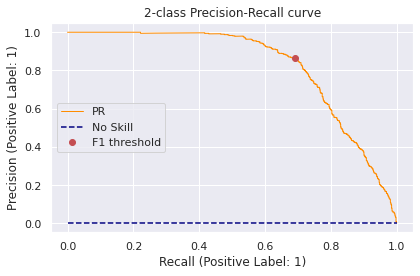

In [41]:
test_loss, test_logits, test_targets = val_epoch(loader=test_loader, 
                                                  model=model, 
                                                  loss_func=criterion,  
                                                  device=device,
                                                  kind='test')
# scoring
test_targets = test_targets.numpy()
test_probs = torch.sigmoid(test_logits).numpy()
pred_labels = (test_probs >= threshold).astype(int)
precision, recall, thresholds = precision_recall_curve(test_targets, test_probs)
threshold_idx = np.argmin(np.abs(thresholds - threshold))
print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision_score(test_targets, pred_labels): 0.4f}',
      f'Rec: {recall_score(test_targets, pred_labels): 0.4f}', f'fraud ct: {pred_labels.sum()}',
      f'actual ct: {int(test_targets.sum())}', f'AUC: {roc_auc_score(test_targets, pred_labels): 0.4f}',
      f'Acc: {accuracy_score(test_targets, pred_labels): 0.4f}',
      f'F1: {f1_score(test_targets, pred_labels): 0.4f}')

print('Confusion Matrix:\n', confusion_matrix(y_true=test_targets, y_pred=pred_labels))

fig, ax = plt.subplots()
no_skill = test_targets.sum()/len(test_targets)
ax.plot(recall, precision, color='darkorange', lw=1, label='PR')
ax.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
ax.plot(recall[threshold_idx], precision[threshold_idx], 'ro', label='F1 threshold')
ax.set_xlabel('Recall (Positive Label: 1)')
ax.set_ylabel('Precision (Positive Label: 1)')
ax.set_title('2-class Precision-Recall curve')
ax.legend()
plt.tight_layout()

## Pytorch Dataloader + Pytorch Training w/ K-Folds

### Build a torch Dataset

In [16]:
col_order = ['step', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest',
             'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'errorOrigAmount', 'type_CASH_OUT', 'type_TRANSFER', 'isFraud']
train_cols = col_order[:-1]

 
train_df = train_df[col_order]
val_df = val_df[col_order]
test_df = test_df[col_order]

assert isinstance(test_df, (pd.DataFrame, cudf.DataFrame)) and \
       isinstance(train_df, (pd.DataFrame, cudf.DataFrame))


### Build Utility functions - Train Loop and Val/Test Loop

In [17]:
def train_epoch(loader, batch_size, model, optimizer, loss_func,  device):
    """Train model through a single epoch"""
    # set model into train mode and zero all parameter gradients
    model.train()
    model.zero_grad()
    progress_bar = tqdm(range(len(loader)//batch_size + 1))
    train_loss = torch.zeros(len(loader), requires_grad=False, device=device)

    for incr in progress_bar:
        batch = loader.iloc[incr*batch_size:(incr+1)*batch_size]
        features = torch.tensor(batch[train_cols].values, device=device)
        targ = torch.tensor(batch[['isFraud']].values, device=device).float()

        # make prediction
        logits = model(features)

        # calculate loss
        loss = loss_func(logits, targ)
        
        batch_loss = loss.detach()
        
        # calculate grads and optimize
        loss.backward()
        optimizer.step()
        for param in model.parameters():
            param.grad = None
        train_loss[incr] = batch_loss

    progress_bar.set_description(f'loss: {train_loss.mean():.5f}')
    return train_loss


def val_epoch(loader, batch_size, model, loss_func, device):
    """Run model through validation dataset"""
    # set model to eval mode
    model.eval()
    val_loss = []
    val_logits = []
    val_targets = []
    val_loss = torch.zeros(len(loader), requires_grad=False, device=device)

    with torch.no_grad():
        progress_bar = tqdm(range(len(loader)//batch_size + 1))
        for incr in progress_bar:
            batch = loader.iloc[incr*batch_size:(incr+1)*batch_size]
            features = torch.tensor(batch[train_cols].values, device=device)
            targ = torch.tensor(batch[['isFraud']].values, device=device).float()

            # make prediction
            logits = model(features)
            
            # calculate loss
            loss = loss_func(logits, targ)
            
            batch_loss = loss.detach()
            
            # save some data
            val_targets.append(targ.detach())
            val_logits.append(logits.detach())
            val_loss[incr] = batch_loss

        progress_bar.set_description(f'val_loss: {val_loss.mean():.5f}')

        val_loss = val_loss.mean()
    
    val_logits = torch.cat(val_logits)
    val_targets = torch.cat(val_targets)
    return val_loss, val_logits, val_targets

In [18]:
def test_em(loader, batch_size, model, loss_func, threshold, device):
    test_loss, test_logits, test_targets = val_epoch(loader=loader, 
                                                     batch_size=batch_size,
                                                     model=model, 
                                                     loss_func=loss_func,  
                                                     device=device)

    # scoring
    test_targets = test_targets.cpu().numpy()
    test_probs = torch.sigmoid(test_logits).cpu().numpy()
    pred_labels = (test_probs >= threshold).astype(int)
    
    print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision_score(test_targets, pred_labels): 0.4f}',
          f'Rec: {recall_score(test_targets, pred_labels): 0.4f}', f'fraud ct: {pred_labels.sum()}',
          f'actual ct: {int(test_targets.sum())}', f'AUC: {roc_auc_score(test_targets, pred_labels): 0.4f}',
          f'Acc: {accuracy_score(test_targets, pred_labels): 0.4f}',
          f'F1: {f1_score(test_targets, pred_labels): 0.4f}')
    
    print('Confusion Matrix:\n', confusion_matrix(y_true=test_targets, y_pred=pred_labels))

### Run

In [19]:
# constants
LR = 0.001
EPOCHS = 1 #20
NUM_WORKERS = 0
TRAIN_BATCH_SIZE = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We can loop over both models, and use K-Fold CV in a stratified manner (since dataset is imbalanced) and evaluate over a number of epochs.

In [21]:

for DLmodel in [FunNet(train_cols)
#     NNModel(input_cols=train_cols, hidden_dim=32),
#                 NNModel(input_cols=train_cols, hidden_dim=16)
               ]:
    kfolds = 4  # number of k-folds
    strat_kfold = StratifiedKFold(n_splits=kfolds)

    best_precisions = []
    best_epochs = []

    for foldnum, (train_idx, val_idx) in enumerate(strat_kfold.split(cp.asnumpy(cp.asarray(train_df.index.values)), 
                                                                     cp.asnumpy(cp.asarray(train_df['isFraud'].values))
                                                                    )):

        print(f'K-Fold {foldnum+1} of {kfolds}')

        model = DLmodel.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.BCEWithLogitsLoss()

        all_preds = []
        all_targets = []
        best_f1 = 0
        best_epoch = 0

        for epoch in range(EPOCHS):
            print(f'Epoch: {epoch}')
            
            train_loss = train_epoch(loader=train_df.iloc[train_idx], 
                                     batch_size=TRAIN_BATCH_SIZE,
                                     model=model, 
                                     optimizer=optimizer, 
                                     loss_func=criterion,  
                                     device=device)
            val_loss, val_logits, val_targets = val_epoch(loader=train_df.iloc[val_idx],
                                                          batch_size=2**16,
                                                          model=model, 
                                                          loss_func=criterion,  
                                                          device=device)

            # scoring
            val_targets = val_targets.cpu().numpy()
            val_probs = torch.sigmoid(val_logits).squeeze().cpu().numpy()

            precision, recall, thresholds = precision_recall_curve(val_targets, val_probs)
            threshold_idx = np.argmax((2 * precision * recall)/ (precision + recall))
            pred_labels = (val_probs >= thresholds[threshold_idx]).astype(int)
            f1 = f1_score(val_targets, pred_labels)
            print(f'Thresh: {thresholds[threshold_idx]: 0.4f}', f'Prec: {precision[threshold_idx]: 0.4f}',
                  f'Rec: {recall[threshold_idx]: 0.4f}', f'fraud ct: {pred_labels.sum()}',
                  f'actual ct: {int(val_targets.sum())}', f'AUC: {roc_auc_score(val_targets, pred_labels): 0.4f}',
                  f'Acc: {accuracy_score(val_targets, pred_labels): 0.4f}',
                  f'F1: {f1: 0.4f}')

            if f1 > best_f1:
                best_f1 = f1
                best_epoch = epoch
                save_checkpoint(model, optimizer, epoch, best_f1, model._name, threshold=thresholds[threshold_idx],
                                k_fold=foldnum+1)

        print('Confusion Matrix:\n', confusion_matrix(y_true=val_targets, y_pred=pred_labels), flush=True)

        model, threshold = load_checkpoint(model._name, model, device)
        test_em(loader=test_df,
                batch_size=2**32,
                model=model,
                loss_func=criterion,
                threshold=threshold,
                device=device)

K-Fold 0 of 4
Epoch: 0


  0%|          | 0/3288 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Thresh:  0.0407 Prec:  0.8571 Rec:  0.6133 fraud ct: 1190 actual ct: 1663 AUC:  0.8065 Acc:  0.9986 F1:  0.7150
Confusion Matrix:
 [[559175    170]
 [   643   1020]]


  0%|          | 0/1 [00:00<?, ?it/s]

Thresh:  0.0407 Prec:  0.8149 Rec:  0.6114 fraud ct: 616 actual ct: 821 AUC:  0.8055 Acc:  0.9984 F1:  0.6987
Confusion Matrix:
 [[276106    114]
 [   319    502]]
K-Fold 1 of 4
Epoch: 0


  0%|          | 0/3288 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Thresh:  0.0291 Prec:  0.8389 Rec:  0.5857 fraud ct: 1161 actual ct: 1663 AUC:  0.7927 Acc:  0.9984 F1:  0.6898
Confusion Matrix:
 [[559158    187]
 [   689    974]]


  0%|          | 0/1 [00:00<?, ?it/s]

Thresh:  0.0291 Prec:  0.8189 Rec:  0.6224 fraud ct: 624 actual ct: 821 AUC:  0.8110 Acc:  0.9985 F1:  0.7073
Confusion Matrix:
 [[276107    113]
 [   310    511]]
K-Fold 2 of 4
Epoch: 0


  0%|          | 0/3288 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Thresh:  0.0105 Prec:  0.8557 Rec:  0.6130 fraud ct: 1192 actual ct: 1664 AUC:  0.8063 Acc:  0.9985 F1:  0.7143
Confusion Matrix:
 [[559172    172]
 [   644   1020]]


  0%|          | 0/1 [00:00<?, ?it/s]

Thresh:  0.0105 Prec:  0.8364 Rec:  0.6541 fraud ct: 642 actual ct: 821 AUC:  0.8269 Acc:  0.9986 F1:  0.7341
Confusion Matrix:
 [[276115    105]
 [   284    537]]
K-Fold 3 of 4
Epoch: 0


  0%|          | 0/3288 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Thresh:  0.0007 Prec:  0.9114 Rec:  0.5009 fraud ct: 914 actual ct: 1663 AUC:  0.7504 Acc:  0.9984 F1:  0.6465
Confusion Matrix:
 [[559263     81]
 [   830    833]]


  0%|          | 0/1 [00:00<?, ?it/s]

Thresh:  0.0007 Prec:  0.9071 Rec:  0.4994 fraud ct: 452 actual ct: 821 AUC:  0.7496 Acc:  0.9984 F1:  0.6441
Confusion Matrix:
 [[276178     42]
 [   411    410]]


Plot of precision-recall curve.

  0%|          | 0/1 [00:00<?, ?it/s]

Thresh:  0.0007 Prec:  0.9071 Rec:  0.4994 fraud ct: 452 actual ct: 821 AUC:  0.7496 Acc:  0.9984 F1:  0.6441
Confusion Matrix:
 [[276178     42]
 [   411    410]]


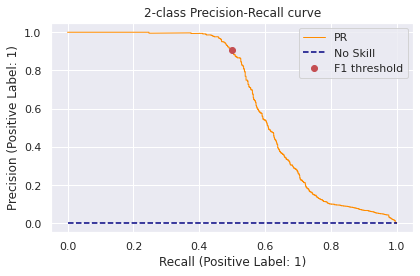

In [24]:
test_loss, test_logits, test_targets = val_epoch(loader=test_df, 
                                                 batch_size=2**32,
                                                 model=model, 
                                                 loss_func=criterion,  
                                                 device=device)
# scoring
test_targets = test_targets.cpu().numpy()
test_probs = torch.sigmoid(test_logits).cpu().numpy()
pred_labels = (test_probs >= threshold).astype(int)
precision, recall, thresholds = precision_recall_curve(test_targets, test_probs)
threshold_idx = np.argmin(np.abs(thresholds - threshold))
print(f'Thresh: {threshold: 0.4f}', f'Prec: {precision_score(test_targets, pred_labels): 0.4f}',
      f'Rec: {recall_score(test_targets, pred_labels): 0.4f}', f'fraud ct: {pred_labels.sum()}',
      f'actual ct: {int(test_targets.sum())}', f'AUC: {roc_auc_score(test_targets, pred_labels): 0.4f}',
      f'Acc: {accuracy_score(test_targets, pred_labels): 0.4f}',
      f'F1: {f1_score(test_targets, pred_labels): 0.4f}')

print('Confusion Matrix:\n', confusion_matrix(y_true=test_targets, y_pred=pred_labels))

fig, ax = plt.subplots()
no_skill = test_targets.sum()/len(test_targets)
ax.plot(recall, precision, color='darkorange', lw=1, label='PR')
ax.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='No Skill')
ax.plot(recall[threshold_idx], precision[threshold_idx], 'ro', label='F1 threshold')
ax.set_xlabel('Recall (Positive Label: 1)')
ax.set_ylabel('Precision (Positive Label: 1)')
ax.set_title('2-class Precision-Recall curve')
ax.legend()
plt.tight_layout()